## **Serving LLMs: Reducing latency**

Starting with a hosted LLM (e.g. Open AI endpoints) is a great way to get started and prototype quickly. However, many organisations have concerns about sharing too much information with third parties, or they want a more specialised model. This is where open source models become more favourable.

However, ML Engineers will soon run in to several problems: infrastructure and optimization challenges not present with hosted solutions.  One such challenge is latency far higher than we'll have been used to (we'll discuss latency vs. throughput in other notebooks).

This notebook shows an approach to reducing latency using an open source model (GPT2 in this case).

Broadly, we'll look at a version of "KV-Caching" (key-value caching) in the attention layer of the transformer.

In each iteration of token generation, we store the outputs (including past key values from the transformer layers) and reuse them for generating the next token. This approach avoids recomputing attention for the entire input sequence every time a new token is generated.

1. Classic Approach

2. Caching key-value pairs (KV-Caching ~ kind-of)

3. Class implementation for re-use

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

c:\Users\arian\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **We'll use GPT2**

In [2]:
model_name = "./models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# If you've not downloaded before, run this
#model_name = "openai-community/gpt2"
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModelForCausalLM.from_pretrained(model_name)
#model_name = "./models/gpt2"
#tokenizer.save_pretrained(model_name)
#model.save_pretrained("./models/gpt2")

### **Component walkthrough**

In [5]:
prompt = "Good afternoon, thanks for email"
inputs = tokenizer(prompt, return_tensors="pt")

print(f"Inputs: {inputs}\n")

Inputs: {'input_ids': tensor([[10248,  6672,    11,  5176,   329,  3053]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}



In [8]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()


print(f"\nNext token id: {next_token_id}\t")
print(f"Decoded:\t{tokenizer.decode(next_token_id)}")

top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
print(f"Top N tokens:\n{tokens}")


Next token id: 278	
Decoded:	ing
Top N tokens:
['ing', '.', '!', ',', ' and', ' from', ',"', ' me', '."', '!"']


### **1. Classic Approach**
`next_inputs` is updated with the new `input_ids` and `attention_mask` for the next iteration.

1.4297683238983154 s
['ing', ' me', '.', ' I', "'m", ' going', ' to', ' be', ' back', ' in', ' a', ' few', ' days', '.', ' I', "'m", ' going', ' to', ' be', ' back', ' in', ' a', ' few', ' days', '.']


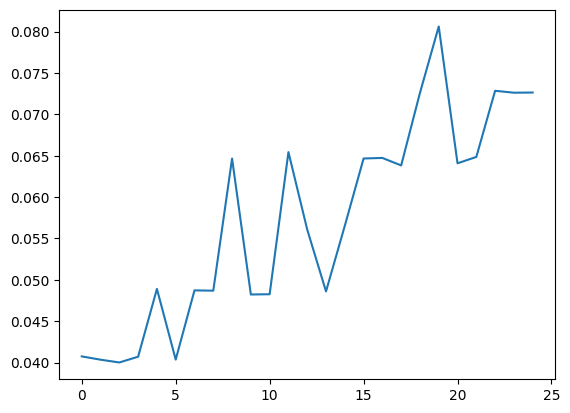

In [10]:
N_TOKENS = 25

prompt = "Good afternoon, thanks for email"
inputs = tokenizer(prompt, return_tensors="pt")

next_inputs = inputs
generated_tokens = []
durations_s = []

def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id


for _ in range(N_TOKENS):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]

    next_inputs = {
        "input_ids": torch.cat([next_inputs["input_ids"], next_token_id.reshape((1, 1))], dim=1),
        "attention_mask": torch.cat([next_inputs["attention_mask"], torch.tensor([[1]])], dim=1),
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)

plt.plot(durations_s)
plt.show()

We see as the number of tokens grow the latency increases. This could be an issue for users.

Can we improve this?

### **2. Caching KV**

**Key Changes in the `generate_token_with_past` Function**
Return Value Includes `past_key_values`: Besides returning the next token ID, this function also returns `outputs.past_key_values`. These are the *computed keys and values* for each layer of the transformer model, which represent the attention context from the current and all previous steps.


By returning `past_key_values`, the model can reuse the attention computations from previous tokens, significantly reducing the amount of computation needed for generating subsequent tokens.

In [13]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

next_inputs = inputs
generated_tokens = []
durations_cached_s = []

for _ in range(N_TOKENS):
    t0 = time.time()
    next_token_id, past_key_values = generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]

    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat([next_inputs["attention_mask"], torch.tensor([[1]])], dim=1),
        "past_key_values": past_key_values,
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

0.6897284984588623 s
['ing', ' me', '.', ' I', "'m", ' going', ' to', ' be', ' back', ' in', ' a', ' few', ' days', '.', ' I', "'m", ' going', ' to', ' be', ' back', ' in', ' a', ' few', ' days', '.']


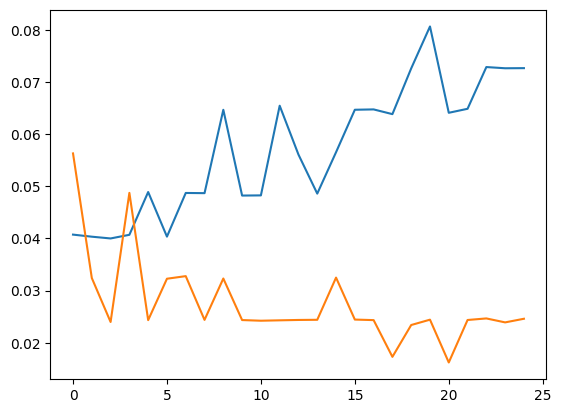

In [14]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()

In [25]:
print(sum(durations_cached_s))
print(sum(durations_s))

0.6897284984588623
1.4297683238983154


We see a dramatic improvement and no degradation over time.


**Reduced Computational Load**: By not reprocessing the entire input sequence for each new token generation, this method significantly reduces the computational load, especially for longer sequences.

**Decreased Latency**: The reduction in computation directly translates to faster token generation times, decreasing overall latency in text generation.

**Scalability**: This approach scales better with longer texts, maintaining efficient performance as sequences grow.

### **Class implementation**

In [15]:
class TokenGenerator:
    def __init__(self, model, tokenizer, n_tokens: int):
        self.model = model
        self.tokenizer = tokenizer
        self.N_TOKENS = n_tokens
        self.generated_tokens = []
        self.durations_cached_s = []

    def _generate_token_with_past(self, inputs):
        with torch.no_grad():
            outputs = self.model(**inputs)
        logits = outputs.logits
        last_logits = logits[0, -1, :]
        next_token_id = last_logits.argmax()
        return next_token_id, outputs.past_key_values

    def _update_next_inputs(self, next_token_id, past_key_values, next_inputs):
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat([next_inputs["attention_mask"], torch.tensor([[1]])], dim=1),
            "past_key_values": past_key_values,
        }
        return next_inputs

    def generate(self, initial_inputs, stream_response=False):
        next_inputs = initial_inputs
        for _ in range(self.N_TOKENS):
            t0 = time.time()
            next_token_id, past_key_values = self._generate_token_with_past(next_inputs)
            self.durations_cached_s.append(time.time() - t0)

            next_inputs = self._update_next_inputs(next_token_id, past_key_values, next_inputs)
            next_token = self.tokenizer.decode(next_token_id)
            if stream_response:
                yield next_token
            else:
                self.generated_tokens.append(next_token)

        if not stream_response:
            print(self.generated_tokens)

        print(f"\n{sum(self.durations_cached_s)} s")

In [16]:
prompt = "It is a fine day on the shores"
inputs = tokenizer(prompt, return_tensors="pt")
n_tokens = 15
generator = TokenGenerator(model, tokenizer, n_tokens)

for token in generator.generate(inputs, True):
     print(token, end='')

 of the Atlantic Ocean.

The U.S. Navy has been
0.5049653053283691 s
